In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

from util import GMMModel

import torch.nn
import torch.optim
import torch.utils.data

import os
import json

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Generate random $f, \vec{\mu}, C$ for each Gaussian model, where the model is <br><br>
$M_{ij} = \sum_{k=1}^{n=ngauss} f G_k(\mu_1, \mu_2, \sigma_1, \sigma_2, \rho)$ <br><br>
Set $f = 1, \sigma_1 = \sigma_2 = 5, \rho = 0.5$ for each GMM. <br><br>
Simulate $D_{ij} = M_{ij} + N_{ij}$, where $N_{ij} \sim G(\sigma = W_{ij}^{-0.5}).$ 

In [2]:
def data_sample(x1, x2, gen, ngauss=1, n=1000):
    
    x1_edges, x2_edges = np.arange(0, x1), np.arange(0, x2)

    x1_mid = len(x1_edges) // 2
    x2_mid = len(x2_edges) // 2
    
    GMM = GMMModel(x1_edges, x2_edges)
    
    data_shape = (n, ) + (len(x1_edges)-1, len(x2_edges)-1)
    params_shape = (n, 2*ngauss) 
    
    data = np.zeros(shape=data_shape)
    params = np.zeros(shape=params_shape)
    
    for i in range(n):
        for g in range(ngauss):
              
            f = 1. / ngauss
            sigma1, sigma2, rho = 5., 5., 0.5

            mu1 = gen.uniform(low=x1_edges[x1_mid-15], high=x1_edges[x1_mid+15])
            mu2 = gen.uniform(low=x2_edges[x2_mid-15], high=x2_edges[x2_mid+15])

            gmm_params = np.array([f, mu1, mu2, sigma1, sigma2, rho])
            
            model = GMM.predict(gmm_params, compute_partials=False)
            noise = gen.normal(loc=0.0, scale=0.001, size=(model.shape))
            
            data[i] += model + noise
            
            params[i, 2*g:2*(g+1)] = gmm_params[1:3].reshape(2)
        
    # Flatten the data
    data = data.reshape(n, -1)
    
    return (data, params)

Generate training and testing data and save them

In [4]:
def save_data(seed=123):

    for i, file in enumerate(['x_train.pt', 'y_train.pt', 'x_test.pt', 'y_test.pt']):
       
        if not os.path.exists(file):
            break
        
        if i == 3:
            print('Data already exists')
            return 
    
    N_train, N_test = 100000, 100000
    gen = np.random.RandomState(seed=seed)

    x_train, y_train = data_sample(41, 41, gen, ngauss=1, n=N_train)
    x_test, y_test = data_sample(41, 41, gen, ngauss=1, n=N_test)

    # For torch
    x_train, y_train = torch.tensor(x_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)) 
    x_test, y_test = torch.tensor(x_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)) 

    torch.save(x_train, 'x_train.pt')
    torch.save(y_train, 'y_train.pt')
    torch.save(x_test, 'x_test.pt')
    torch.save(y_test, 'y_test.pt')
            
    
save_data()

Data already exists


Load Data

In [5]:
for i, file in enumerate(['x_train.pt', 'y_train.pt', 'x_test.pt', 'y_test.pt']):
    if not os.path.exists(file):
        print("{file} doesn't exists.".format(file=file))
        return

    if i == 3:
        break 

x_train, y_train = torch.load('x_train.pt'), torch.load('y_train.pt')
x_test, y_test = torch.load('x_test.pt'), torch.load('y_test.pt')

torch_train_data = torch.utils.data.TensorDataset(x_train, y_train)
torch_test_data = torch.utils.data.TensorDataset(x_test, y_test)

In [6]:
def plot_data(x, y, seed=123):
    
    assert x.shape[0] == y.shape[0]
    
    gen = np.random.RandomState(seed=seed)
    arg = gen.randint(0, x.shape[0])
    
    size = int(np.sqrt(x.shape[1]))
    
    plt.imshow(x[arg].reshape(size, size), origin='lower')
    plt.plot(*y[arg], 'x', ms=25)
    plt.xlabel('$\mu_1$')
    plt.ylabel('$\mu_2$')

def plot_multiple_data(x, y, y_pred, n=4):
    
    assert x.shape[0] == y.shape[0]
    assert y.shape == y_pred.shape
    
    fig, axs = plt.subplots(nrows=n, ncols=n, sharex='col', sharey='row', figsize=(10, 10))
    
    fig.text(0.5, 0.04, '$\mu_1$', ha='center')
    fig.text(0.04, 0.5, '$\mu_2$', va='center', rotation='vertical')
    size = int(np.sqrt(x.shape[1]))
    
    for i, data in enumerate(zip(x[:n**2], y[:n**2], y_pred[:n**2])):
            
        idx, j = i % n, i // n
        
        axs[idx, j].imshow(data[0].reshape(size, size), origin='lower', extent=[0, size, 0, size], cmap=plt.cm.magma)
        axs[idx, j].grid(None)
        axs[idx, j].plot(*data[1], 'w+', ms=30)

        if np.all(data[2]):
            axs[idx, j].plot(*data[2], 'gx', ms=30)

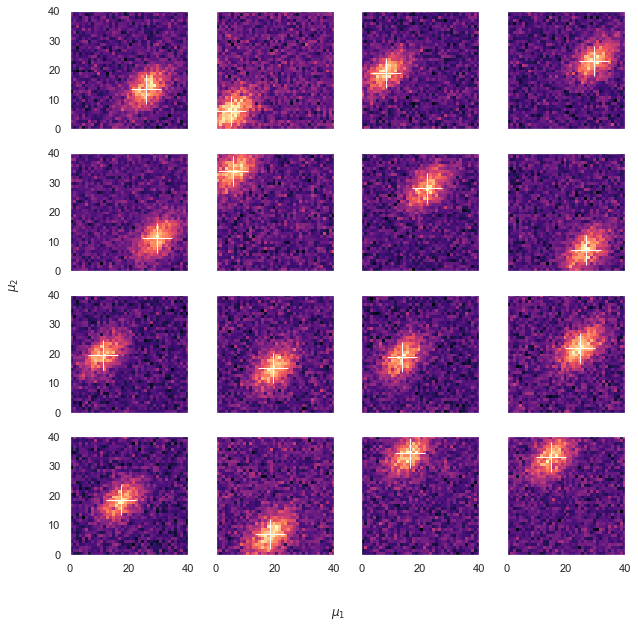

In [7]:
# Sample image
plot_multiple_data(x_train.numpy(), y_train.numpy(), np.zeros(y_train.shape))

Training sample $(D_{ij}, W_{ij}) \to \vec{\mu}$ using torch

In [8]:
class DNN_Torch(torch.nn.Sequential):
    
    def __init__(self, *n_nodes, activation=torch.nn.ReLU, drop=False):
        super(DNN_Torch, self).__init__()
        
        n_inputs = n_nodes[:-1]
        n_outputs = n_nodes[1:]
        
        for depth, (n_inp, n_out) in enumerate(zip(n_inputs, n_outputs)):
            self.add_module(f'LYR{depth}', torch.nn.Linear(n_inp, n_out))
            
            if depth < len(n_inputs) - 1:
                self.add_module(f'ACT{depth}', activation())
            
            if drop: 
                self.add_module(f'DRP{depth}', torch.nn.Dropout(p=0.005))

In [9]:
def learn(model, n_epochs=100, batch_size=200, learning_rate=0.05,
          loss_slice=slice(None, None), n_print=5):
    
    print(f'Model has {np.sum([np.prod(P.shape) for P in model.parameters()])} parameters.')
    loader = torch.utils.data.DataLoader(torch_train_data, batch_size=batch_size, shuffle=True)
    print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    x_test, y_test = torch_test_data.tensors
    train_loss, test_loss = list(), list()
    
    print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
    
    for epoch in range(n_epochs):
        model.train()
        
        for x_train, y_train in loader:
            y_pred = model(x_train)
            loss = loss_fn(y_pred[:,loss_slice], y_train[:,loss_slice])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss.append(float(loss.data))
        model.eval()
        
        y_pred = model(x_test)
        test_loss.append(float(loss_fn(y_pred[:,loss_slice], y_test[:,loss_slice]).data))
        
        if epoch + 1 == print_at[0]:
            print(f'EPOCH {epoch + 1:5d}: TRAIN {train_loss[-1]:.5f} TEST {test_loss[-1]:.5f}')
            print_at = print_at[1:]
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, '.', label='TRAIN')
    plt.plot(test_loss, '.', label='TEST')
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    
    return train_loss, test_loss, y_pred.detach()

Model has 160302 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.17107 TEST 0.16076
EPOCH    40: TRAIN 0.06860 TEST 0.08499
EPOCH    60: TRAIN 0.05351 TEST 0.06665
EPOCH    80: TRAIN 0.08470 TEST 0.07299
EPOCH   100: TRAIN 0.04276 TEST 0.08352


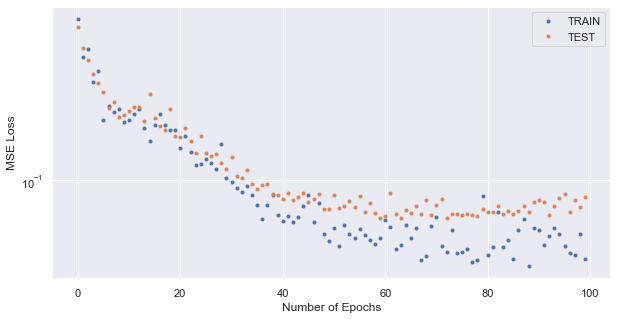

In [10]:
torch.manual_seed(123)
model = DNN_Torch(x_train.size(1), 100, y_train.size(1))
train_loss, test_loss, y_pred = learn(model)

Check predicted $\vec{\mu}$.

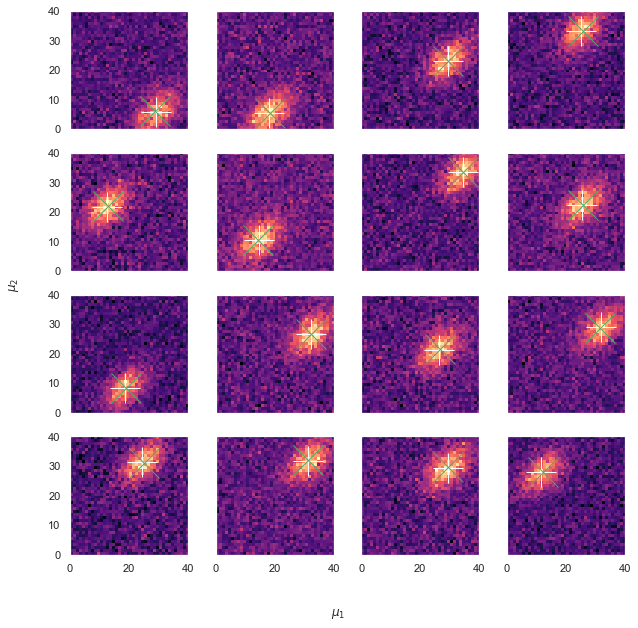

In [11]:
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())

In [12]:
def plot_histogram(test, predicted):
    
    assert test.shape == predicted.shape
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))
    fig.tight_layout()
    
    mu1 = test[:, 0] - predicted[:, 0]
    mu2 = test[:, 1] - predicted[:, 1]
    
    for i, diff in enumerate([mu1, mu2]):
        axs[i].hist(diff, density=True)
        xlabel = "$\mu_{test" + ", {}".format(i+1) + "} - \mu_{pred" + ", {}".format(i+1) + "}$"
        axs[i].set(xlabel=xlabel)
        axs[i].axvline(x=0, color='r', linestyle='--')

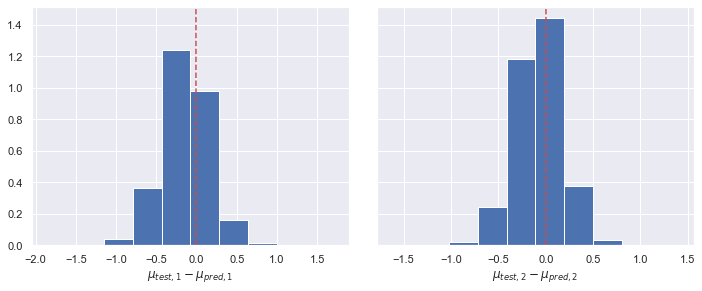

In [13]:
plot_histogram(y_test.numpy(), y_pred.numpy())